In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv

In [ ]:
# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,  # 테스트 데이터 비율 5%로 설정
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['dandelion', 'tulips', 'sunflowers', 'roses', 'daisy']
클래스 수: 5
전체 이미지 개수: 3670
dandelion: 898개
tulips: 799개
sunflowers: 699개
roses: 641개
daisy: 633개
Found 3670 files belonging to 5 classes.
Using 3120 files for training.
Found 3670 files belonging to 5 classes.
Using 550 files for validation.


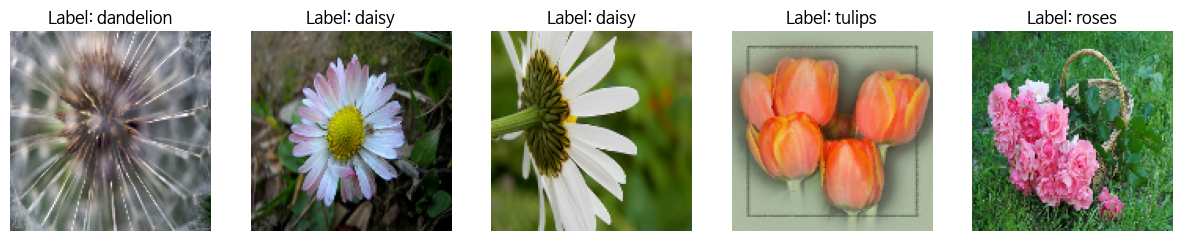

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  # 첫 배치에서 5장만 출력
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

In [ ]:
def build_attention_cnn():
    # 간단한 Self-Attention Layer 추가 CNN
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Attention
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

model_builders = {
        "Attention-CNN": build_attention_cnn
}

results = []
all_results = []
EPOCHS = 30

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()


Evaluating and plotting Attention-CNN ...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ sequential_1[3][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 126, 126,  │        896 │ rescaling_1[3][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 63, 63,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 30, 30,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 30,    │        128 │ max_pooling2d_6[… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 900, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 900, 64)   │     16,640 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,125 (176.27 KB)

 Trainable params: 45,125 (176.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.3479 - loss: 1.4378 - val_accuracy: 0.5509 - val_loss: 1.1047
Epoch 2/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5405 - loss: 1.1030 - val_accuracy: 0.5509 - val_loss: 1.0131
Epoch 3/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5975 - loss: 0.9859 - val_accuracy: 0.5891 - val_loss: 0.9758
Epoch 4/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6162 - loss: 0.9475 - val_accuracy: 0.6782 - val_loss: 0.8541
Epoch 5/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6558 - loss: 0.8718 - val_accuracy: 0.6818 - val_loss: 0.8226
Epoch 6/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6648 - loss: 0.8389 - val_accuracy: 0.6800 - val_loss: 0.8363
Epoch 7/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6749 - loss: 0.8272 - val_accuracy: 0.6655 - val_loss: 0.8202
Epoch 8/500
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6821 - loss: 0.7820 - val_accuracy: 0

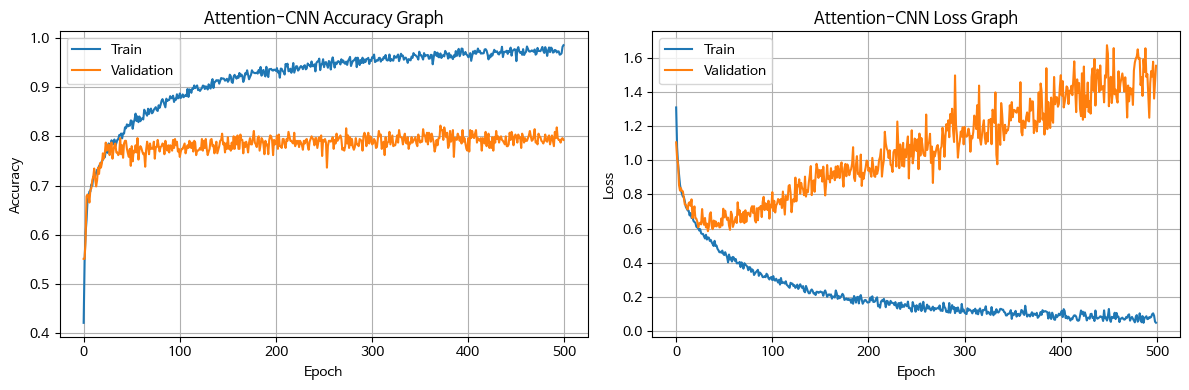

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

model_builders = {
        "Attention-CNN": build_attention_cnn
}

results = []
all_results = []
EPOCHS = 500

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    S

    # Build the model by calling it with a dummy input
    dummy_input = tf.zeros((1, img_height, img_width, 3)) # Create a dummy input with the correct shape
    _ = model(dummy_input) # Call the model with the dummy input to build it

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print(f"\n모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")


모델 성능 비교 테이블:
           모델   정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
Attention-CNN 79.272729 1.552096     45125        45125 2501.34392

모델: Attention-CNN
정확도: 79.27%
총 파라미터 수: 45,125
